In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import matplotlib.pyplot as plt
import os

base_dir = "C:/Users/natha/Documents/Football/Explosiveness"

def analyze_explosiveness(url, league, season):
    def fetch_fbref_data(url, table_index):
        # Fetch the tables from the webpage into a list of DataFrames
        tables = pd.read_html(url, header=1)
        # Get the table at the specified index
        df = tables[table_index]
        return df
    
    season_dir = os.path.join(base_dir, f'{league.replace(" ", "_")}_{season.replace("/", "_")}')
    os.makedirs(season_dir, exist_ok=True)

    # Fetch the data for team explosiveness analysis
    df_team = fetch_fbref_data(url, 0)
    
    # Fetch the data for opposition explosiveness analysis
    df_opposition = fetch_fbref_data(url, 1)

    # Calculate Team Explosiveness Index for both team and opposition
    for df, analysis_type in zip([df_team, df_opposition], ["Team", "Opposition"]):
        df['xG/90'] = df['xG'] / df['90s']
        df['Team Explosiveness Index'] = df['xG/90'] * df['Sh/90']
        df_sorted = df.sort_values(by='Team Explosiveness Index', ascending=False)
        df_explosiveness = df_sorted[['Squad', 'Team Explosiveness Index']]
        
        # Plotting
        plt.figure(figsize=(12, 8))
        plt.barh(df_explosiveness['Squad'], df_explosiveness['Team Explosiveness Index'], color='purple')
        plt.xlabel('Team Explosiveness Index')
        plt.ylabel('Team')
        plt.title(f'{analysis_type} Explosiveness Index {league} {season}')
        plt.gca().invert_yaxis()
        plt.show()

        # Print the data frame
        print(f'{analysis_type} Explosiveness {league} {season}:')
        print(df_explosiveness)
        print("\n")
        
        df_explosiveness.to_csv(os.path.join(season_dir, f'{analysis_type}_Explosiveness.csv'), index=False, encoding='utf-8-sig')

      # Calculate Team Consistency Index for both team and opposition
    for df, analysis_type in zip([df_team, df_opposition], ["Team", "Opposition"]):
        df['npxG/90'] = df['npxG'] / df['90s']
        df['Sh/90'] = df['Sh'] / df['90s']

        # Create the new column 'Team Consistency Index'
        df['Team Consistency Index'] = (df['npxG/90'] / df['Sh/90']) * df['npxG/90']

        # Create a new DataFrame with only 'Squad' and 'Team Consistency Index', sorted by the index
        df_consistency = df[['Squad', 'Team Consistency Index']].sort_values(by='Team Consistency Index', ascending=False)

        # Plotting (adjust as necessary)
        plt.figure(figsize=(12, 8))
        plt.barh(df_consistency['Squad'], df_consistency['Team Consistency Index'], color='green')
        plt.xlabel('Team Consistency Index')
        plt.ylabel('Team')
        plt.title(f'{analysis_type} Consistency Index {league} {season}')
        plt.gca().invert_yaxis()
        plt.show()

        # Print the data frame
        print(f'{analysis_type} Consistency {league} {season}:')
        print(df_consistency)
        print("\n")

        # Save the data frame to a CSV file (adjust the path as necessary)
        df_consistency.to_csv(os.path.join(season_dir, f'{analysis_type}_Consistency.csv'), index=False, encoding='utf-8-sig')

    
    # Selenium part to fetch player data (Specify the correct path to your Edge WebDriver executable)
    edge_driver_path = 'C:\\Users\\natha\\Downloads\\edgedriver_win64\\msedgedriver.exe'

    # Create Edge options
    edge_options = webdriver.EdgeOptions()
    edge_options.use_chromium = True
    edge_options.add_argument('--headless')  # Run in headless mode

    # Set the Edge WebDriver executable path using executable_service
    executable_service = webdriver.EdgeService(executable_path=edge_driver_path)

    # Initialize the EdgeDriver
    driver = webdriver.Edge(service=executable_service, options=edge_options)

    # Navigate to the URL
    driver.get(url)

    # Find the table by its class using the By class
    table = driver.find_element(By.CSS_SELECTOR, '.min_width.sortable.stats_table.shade_zero.now_sortable.sticky_table.eq2.re2.le2')

    # Use pandas to read the table
    df = pd.read_html(table.get_attribute('outerHTML'))[0]

    # Close the browser
    driver.quit()

    # Data cleaning and processing
    df.columns = df.columns.droplevel(level=0)
    column_names = df.columns.get_level_values(-1)
    df.columns = column_names
    df['npxG'] = pd.to_numeric(df['npxG'], errors='coerce')
    df['90s'] = pd.to_numeric(df['90s'], errors='coerce')
    df['PKatt'] = pd.to_numeric(df['PKatt'], errors='coerce')
    df['Sh'] = pd.to_numeric(df['Sh'], errors='coerce')
    df['npSh'] = df['Sh'] - df['PKatt']
    df['npSh/90'] = df['npSh']/df['90s']
    df = df.dropna(subset=['npSh/90', '90s'])
    df['npxG/90'] = df['npxG'] / df['90s']
    df = df[df['90s'] >= 1]

    # Player Explosiveness Analysis
    explosiveness_df = df[['Player', 'npxG/90', 'npSh/90']]
    explosiveness_df['Explosiveness'] = explosiveness_df['npxG/90'] * explosiveness_df['npSh/90']
    explosiveness_df = explosiveness_df.sort_values(by='Explosiveness', ascending=False)
    print(f'Player Explosiveness {league} {season}:')
    print(explosiveness_df.head(50))
    print("\n")

    # Player Consistency Analysis
    df['npxG/90'] = pd.to_numeric(df['npxG/90'], errors='coerce')
    df['npxG'] = pd.to_numeric(df['npxG'], errors='coerce')
    df['npSh'] = pd.to_numeric(df['npSh'], errors='coerce')
    df['npxG_per_shot'] = df['npxG'] / df['npSh']
    df = df.dropna(subset=['npxG_per_shot'])
    df = df[df['npSh'] >= 5]
    consistency_df = df[['Player', 'npxG/90', 'npxG_per_shot']]
    consistency_df['Consistency'] = consistency_df['npxG_per_shot'] * consistency_df['npxG/90']
    sorted_consistency_df = consistency_df.sort_values(by='Consistency', ascending=False)
    print(f'Player Consistency {league} {season}:')
    print(sorted_consistency_df.head(50))
    
    # Create the directory structure and save the data frames
    explosiveness_df.to_csv(os.path.join(season_dir, 'Player_Explosiveness.csv'), index=False, encoding='utf-8-sig')
    sorted_consistency_df.to_csv(os.path.join(season_dir, 'Player_Consistency.csv'), index=False, encoding='utf-8-sig')




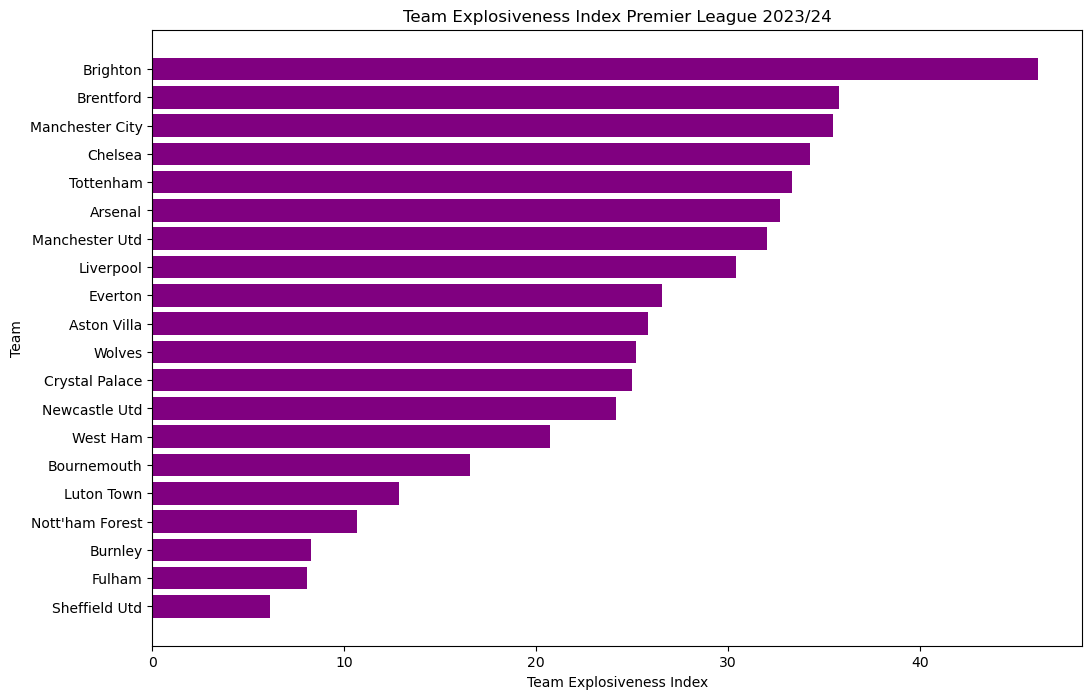

Team Explosiveness Premier League 2023/24:
              Squad  Team Explosiveness Index
4          Brighton                  46.12500
3         Brentford                  35.76875
12  Manchester City                  35.47500
6           Chelsea                  34.23750
17        Tottenham                  33.30625
0           Arsenal                  32.68125
13   Manchester Utd                  32.00000
10        Liverpool                  30.40000
8           Everton                  26.55000
1       Aston Villa                  25.83750
19           Wolves                  25.18750
7    Crystal Palace                  25.01250
14    Newcastle Utd                  24.15000
18         West Ham                  20.70000
2       Bournemouth                  16.56250
11       Luton Town                  12.83700
15  Nott'ham Forest                  10.68750
5           Burnley                   8.26400
9            Fulham                   8.04375
16    Sheffield Utd                  

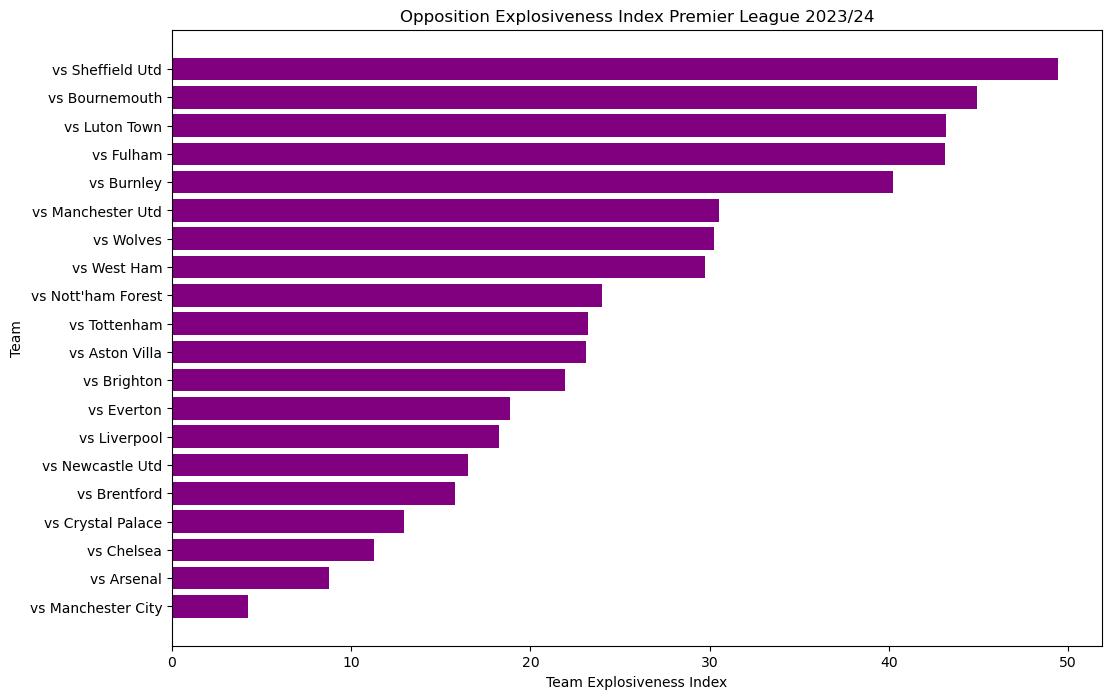

Opposition Explosiveness Premier League 2023/24:
                 Squad  Team Explosiveness Index
16    vs Sheffield Utd                  49.40625
2       vs Bournemouth                  44.93125
11       vs Luton Town                  43.20000
9            vs Fulham                  43.14375
5           vs Burnley                  40.20000
13   vs Manchester Utd                  30.52500
19           vs Wolves                  30.22500
18         vs West Ham                  29.73125
15  vs Nott'ham Forest                  24.00000
17        vs Tottenham                  23.23125
1       vs Aston Villa                  23.07500
4          vs Brighton                  21.93750
8           vs Everton                  18.84375
10        vs Liverpool                  18.21875
14    vs Newcastle Utd                  16.53750
3         vs Brentford                  15.81250
7    vs Crystal Palace                  12.93750
6           vs Chelsea                  11.28750
0           vs Arsen

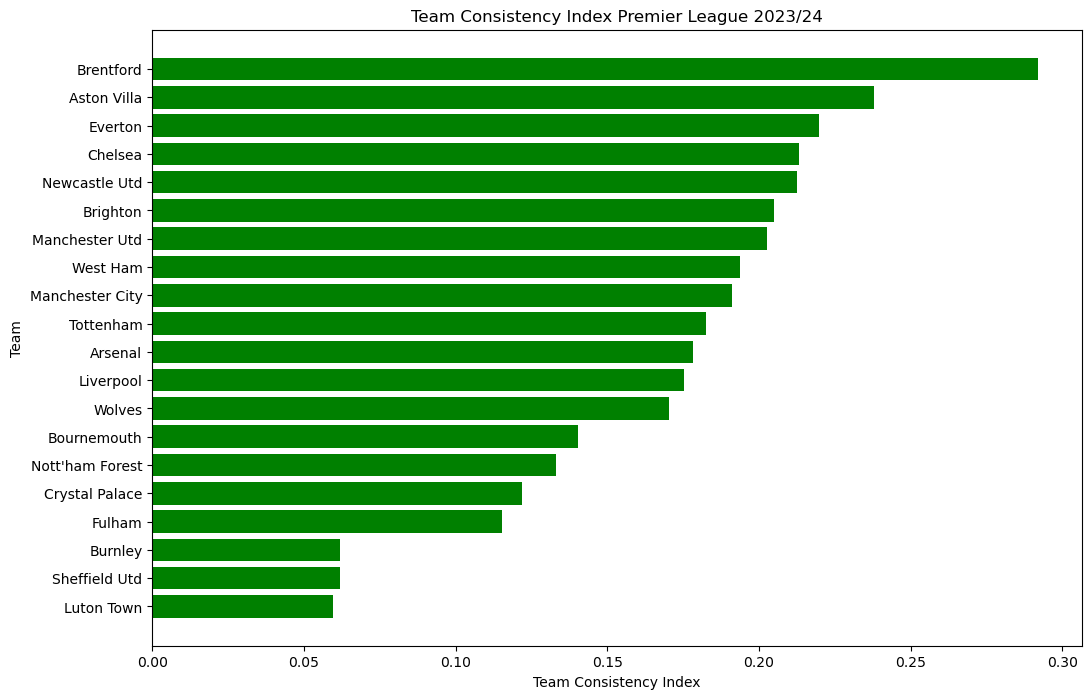

Team Consistency Premier League 2023/24:
              Squad  Team Consistency Index
3         Brentford                0.291907
1       Aston Villa                0.237783
8           Everton                0.219661
6           Chelsea                0.213068
14    Newcastle Utd                0.212545
4          Brighton                0.205000
13   Manchester Utd                0.202500
18         West Ham                0.193802
12  Manchester City                0.190947
17        Tottenham                0.182500
0           Arsenal                0.178135
10        Liverpool                0.175352
19           Wolves                0.170363
2       Bournemouth                0.140450
15  Nott'ham Forest                0.133224
7    Crystal Palace                0.121884
9            Fulham                0.115227
5           Burnley                0.061935
16    Sheffield Utd                0.061838
11       Luton Town                0.059524




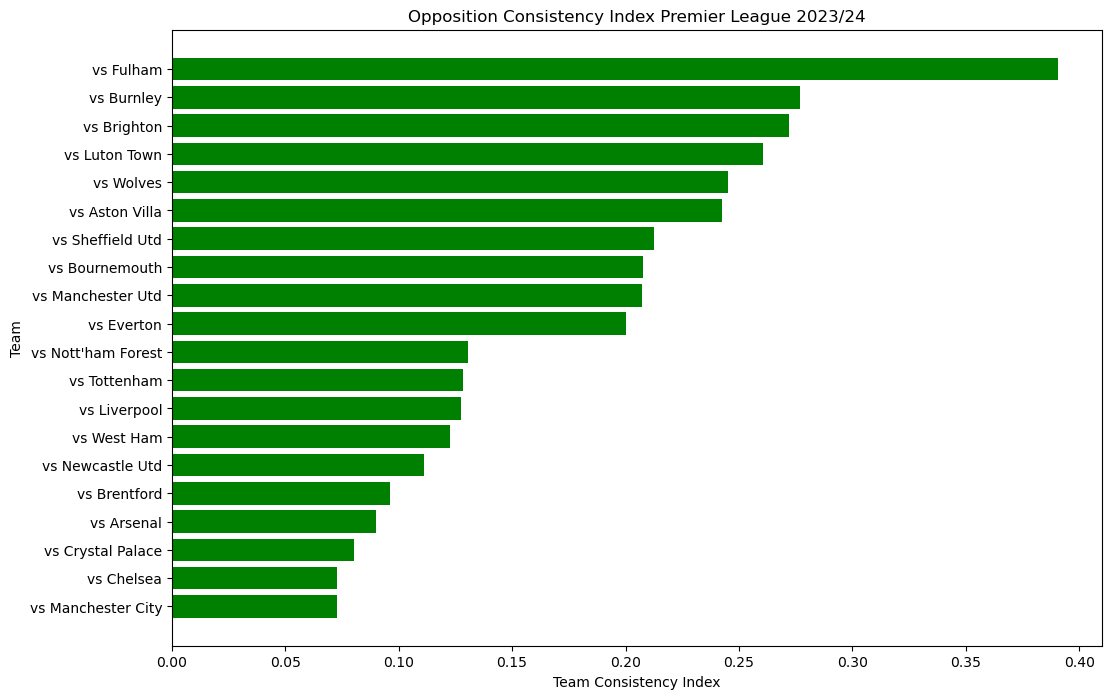

Opposition Consistency Premier League 2023/24:
                 Squad  Team Consistency Index
9            vs Fulham                0.390508
5           vs Burnley                0.277099
4          vs Brighton                0.272222
11       vs Luton Town                0.260802
19           vs Wolves                0.245323
1       vs Aston Villa                0.242356
16    vs Sheffield Utd                0.212500
2       vs Bournemouth                0.207627
13   vs Manchester Utd                0.207424
8           vs Everton                0.200000
15  vs Nott'ham Forest                0.130667
17        vs Tottenham                0.128178
10        vs Liverpool                0.127682
18         vs West Ham                0.122570
14    vs Newcastle Utd                0.111157
3         vs Brentford                0.096182
0           vs Arsenal                0.090066
7    vs Crystal Palace                0.080222
6           vs Chelsea                0.072917
12  vs Manche

C:\Users\natha\AppData\Local\Temp\ipykernel_10436\1116655284.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  explosiveness_df['Explosiveness'] = explosiveness_df['npxG/90'] * explosiveness_df['npSh/90']
C:\Users\natha\AppData\Local\Temp\ipykernel_10436\1116655284.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consistency_df['Consistency'] = consistency_df['npxG_per_shot'] * consistency_df['npxG/90']


Player Explosiveness Premier League 2023/24:
                 Player   npxG/90   npSh/90  Explosiveness
274        Darwin Núñez  1.333333  7.500000      10.000000
395       Callum Wilson  1.272727  6.363636       8.099174
126       Evan Ferguson  1.043478  5.652174       5.897921
242         Neal Maupay  1.166667  4.166667       4.861111
154      Erling Haaland  0.794872  4.102564       3.261012
93       Arnaut Danjuma  0.642857  5.000000       3.214286
56         David Brooks  0.800000  4.000000       3.200000
116     Odsonne Édouard  0.605263  5.000000       3.026316
118      Anthony Elanga  0.600000  5.000000       3.000000
172     Nicolas Jackson  0.769231  3.846154       2.958580
35        Harvey Barnes  0.700000  4.000000       2.800000
397         Yoane Wissa  0.648649  4.054054       2.629657
239     Pape Matar Sarr  0.500000  4.166667       2.083333
125        Eberechi Eze  0.425000  4.750000       2.018750
53         Jarrod Bowen  0.575000  3.250000       1.868750
29        T

In [5]:
analyze_explosiveness("https://fbref.com/en/comps/9/shooting/Premier-League-Stats", "Premier League", "2023/24")

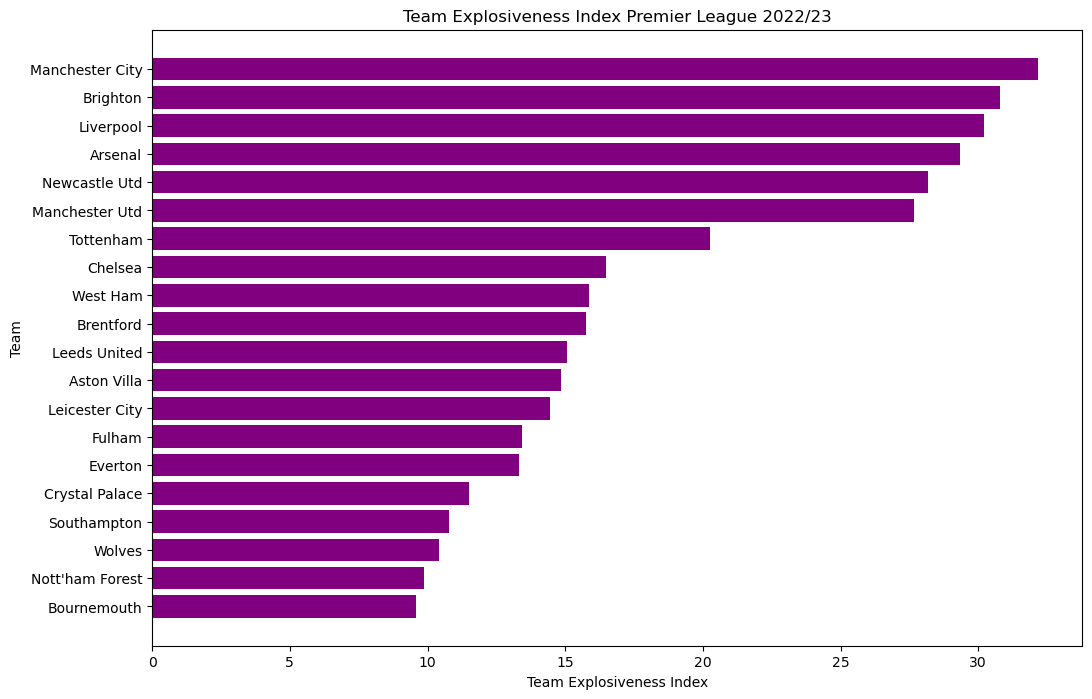

Team Explosiveness Premier League 2022/23:
              Squad  Team Explosiveness Index
12  Manchester City                 32.163447
4          Brighton                 30.805289
11        Liverpool                 30.224526
0           Arsenal                 29.327632
14    Newcastle Utd                 28.174737
13   Manchester Utd                 27.667921
17        Tottenham                 20.240447
5           Chelsea                 16.491316
18         West Ham                 15.873474
3         Brentford                 15.739579
9      Leeds United                 15.068211
1       Aston Villa                 14.848632
10   Leicester City                 14.434316
8            Fulham                 13.434474
7           Everton                 13.334000
6    Crystal Palace                 11.510763
16      Southampton                 10.784184
19           Wolves                 10.420211
15  Nott'ham Forest                  9.856026
2       Bournemouth                  

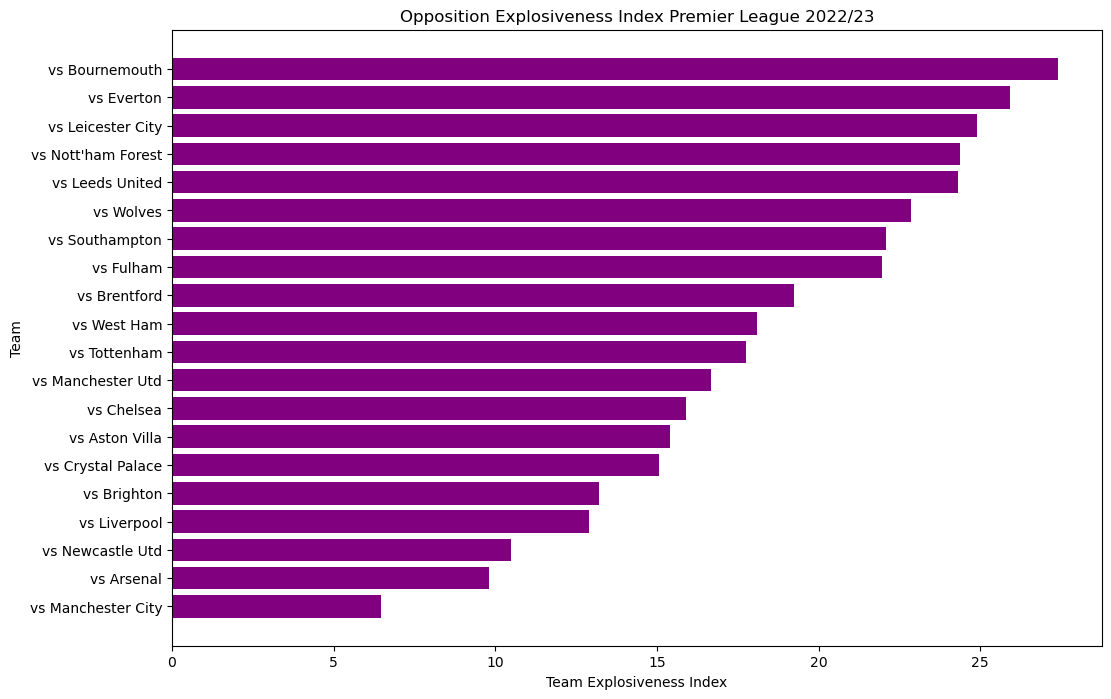

Opposition Explosiveness Premier League 2022/23:
                 Squad  Team Explosiveness Index
2       vs Bournemouth                 27.392921
7           vs Everton                 25.934211
10   vs Leicester City                 24.892842
15  vs Nott'ham Forest                 24.362211
9      vs Leeds United                 24.298105
19           vs Wolves                 22.856579
16      vs Southampton                 22.088421
8            vs Fulham                 21.960632
3         vs Brentford                 19.250895
18         vs West Ham                 18.089737
17        vs Tottenham                 17.761211
13   vs Manchester Utd                 16.685053
5           vs Chelsea                 15.888158
1       vs Aston Villa                 15.418421
6    vs Crystal Palace                 15.050237
4          vs Brighton                 13.210526
11        vs Liverpool                 12.899132
14    vs Newcastle Utd                 10.473158
0           vs Arsen

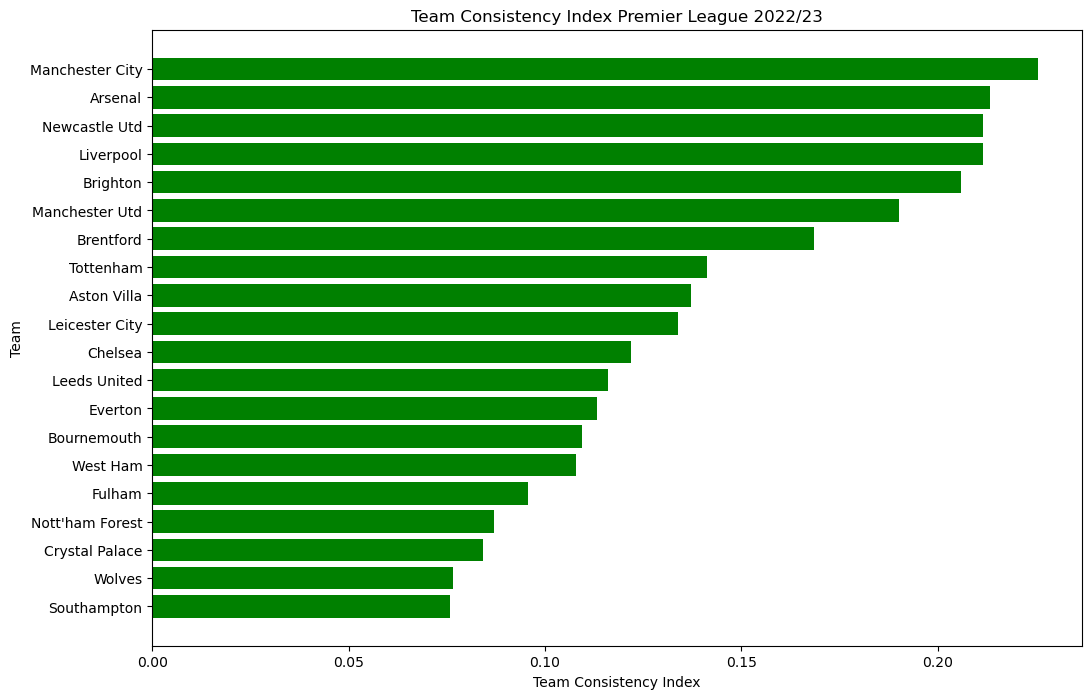

Team Consistency Premier League 2022/23:
              Squad  Team Consistency Index
12  Manchester City                0.225478
0           Arsenal                0.213333
14    Newcastle Utd                0.211586
11        Liverpool                0.211501
4          Brighton                0.205810
13   Manchester Utd                0.190191
3         Brentford                0.168445
17        Tottenham                0.141127
1       Aston Villa                0.137301
10   Leicester City                0.133983
5           Chelsea                0.121886
9      Leeds United                0.116099
7           Everton                0.113160
2       Bournemouth                0.109524
18         West Ham                0.107843
8            Fulham                0.095790
15  Nott'ham Forest                0.087028
6    Crystal Palace                0.084250
19           Wolves                0.076583
16      Southampton                0.075841




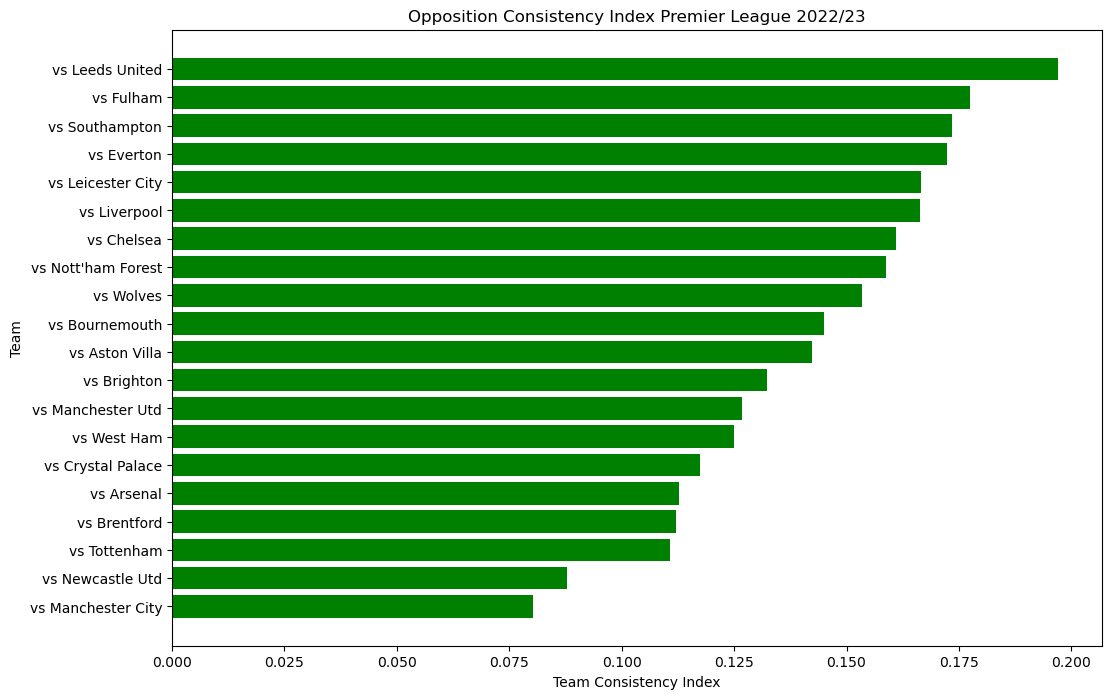

Opposition Consistency Premier League 2022/23:
                 Squad  Team Consistency Index
9      vs Leeds United                0.196927
8            vs Fulham                0.177508
16      vs Southampton                0.173377
7           vs Everton                0.172355
10   vs Leicester City                0.166528
11        vs Liverpool                0.166351
5           vs Chelsea                0.160959
15  vs Nott'ham Forest                0.158771
19           vs Wolves                0.153543
2       vs Bournemouth                0.144994
1       vs Aston Villa                0.142404
4          vs Brighton                0.132250
13   vs Manchester Utd                0.126844
18         vs West Ham                0.125043
6    vs Crystal Palace                0.117374
0           vs Arsenal                0.112760
3         vs Brentford                0.112052
17        vs Tottenham                0.110749
14    vs Newcastle Utd                0.087799
12  vs Manche

C:\Users\natha\AppData\Local\Temp\ipykernel_10436\1116655284.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  explosiveness_df['Explosiveness'] = explosiveness_df['npxG/90'] * explosiveness_df['npSh/90']
C:\Users\natha\AppData\Local\Temp\ipykernel_10436\1116655284.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consistency_df['Consistency'] = consistency_df['npxG_per_shot'] * consistency_df['npxG/90']


Player Explosiveness Premier League 2022/23:
                    Player   npxG/90   npSh/90  Explosiveness
393           Darwin Núñez  0.643617  4.468085       2.875736
225         Erling Haaland  0.750000  3.538961       2.654221
544            Deniz Undav  0.642857  3.857143       2.479592
573          Callum Wilson  0.722488  3.205742       2.316110
391          Eddie Nketiah  0.677686  3.388430       2.296291
384           Reiss Nelson  0.458333  5.000000       2.291667
462         Salomón Rondón  0.666667  3.333333       2.222222
176             João Félix  0.466667  4.380952       2.044444
258          Gabriel Jesus  0.576419  3.275109       1.887836
92      Julio César Enciso  0.444444  4.222222       1.876543
158             Jhon Durán  0.400000  4.666667       1.866667
197     Alejandro Garnacho  0.476190  3.809524       1.814059
177          Evan Ferguson  0.500000  3.396226       1.698113
438        Marcus Rashford  0.481250  3.375000       1.624219
470          Mohamed Sala

In [6]:
analyze_explosiveness("https://fbref.com/en/comps/9/2022-2023/shooting/2022-2023-Premier-League-Stats", "Premier League", "2022/23")